In [1]:
import torch
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset, random_split
from torchensemble import VotingRegressor, SnapshotEnsembleRegressor
import matplotlib.pyplot as plt
from fitting import create_ensemble, get_data, get_datasets

import sys
sys.path.append("../")

folder = "../test_case_4/"
save_dir = "alpha_1000"

all_k, all_images, bins, xx = get_data(folder)
train_dset, test_dset = get_datasets(all_k, all_images, save_dir)
gt_initial_beam = torch.load(folder + "ground_truth_dist.pt")

from torch_track import Beam
defaults = {
    "s": torch.tensor(0.0).float(),
    "p0c": torch.tensor(10.0e6).float(),
    "mc2": torch.tensor(0.511e6).float(),
}

gt_initial_beam = Beam(gt_initial_beam, **defaults)


bandwidth = torch.tensor(0.0)
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)
ensemble = ensemble
ensemble.cuda();

/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([20, 1, 200, 200])
torch.Size([20, 1])
torch.Size([200])


In [2]:
bins[1] - bins[0]

tensor(0.0003)

In [3]:
train_k = train_dset.k
train_k = train_k.cuda()

train_im = train_dset.images
train_im = train_im.cpu()

test_k = test_dset.k
test_k = test_k.cuda()

test_im = test_dset.images
test_im = test_im.cpu()

In [4]:
recompute_images = True
with torch.no_grad():
    if recompute_images:
        dist = torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6))
        custom_beam = dist.sample([100000]).cuda()

        model_pred = torch.cat(
            [ensemble[i](all_k[:,:1].cuda())[0].unsqueeze(0) for i in range(len(ensemble))]
        )
        model_pred = torch.transpose(model_pred.squeeze(dim=2), 0,1)
        model_pred = model_pred.cpu().detach()

        #torch.save(train_pred, "train_pred_images.pt")
        #torch.save(test_pred, "test_pred_images.pt")
    else:
        pass
        #train_pred = torch.load("train_pred_images.pt")
        #test_pred = torch.load("test_pred_images.pt")

In [5]:
# generate beams from model
pred_initial_beams = [ele.beam_generator() for ele in ensemble]


torch.Size([20, 1, 200, 200])
tensor(0.1883, device='cuda:0', grad_fn=<StdBackward0>)
tensor(0.0390, device='cuda:0', grad_fn=<StdBackward0>)


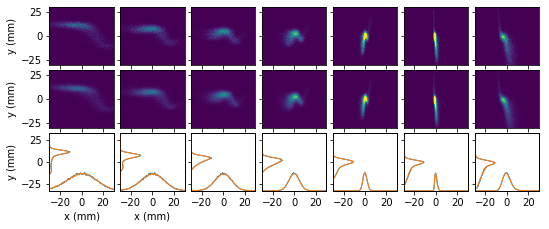

In [17]:
from visualization import add_image, add_projection, add_image_projection
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.axes import SubplotBase


    
print(all_images.shape)
plot_bins = bins
#plot_bins = plot_bins * 1e3

vmax = 10e5
linewidth=1.0

idxs = np.arange(0,20,3)
plot_bins = bins
extent = 30
im_vmax = all_images[idxs[-1],0].max().cpu()

fig,ax = plt.subplots(3,len(idxs), sharex="col",sharey="row")
fig.subplots_adjust(wspace=0.1, right=0.975, top=0.975, hspace=0.1)
fig.set_size_inches(8,3)

for j, idx in enumerate(idxs):

    ax[0][j].pcolor(xx[0]*1e3,xx[1]*1e3, all_images[idx,0].cpu(),vmax=im_vmax*1.1)
    ax[1][j].pcolor(xx[0]*1e3,xx[1]*1e3, model_pred[idx,0].cpu(),vmax=im_vmax*1.1)

    ax[0][j].collections[0].set_rasterized(True)

    colors = ["C0","C1"]
    axa = ax[2][j].twinx()
    axb = ax[2][j].twiny()
    
    for h, ele in enumerate([all_images.cpu(), model_pred.cpu()]):
        axa = add_image_projection(axa, ele[idx], plot_bins, "x", scale_x=1e3,c=colors[h])
        axb = add_image_projection(axb, ele[idx], plot_bins, "y", scale_x=1e3, c=colors[h])
        
        
       
    for ele in [axa,axb]:
        for line in ele.get_lines():
            line.set(linewidth=linewidth)    
        ele.get_lines()[0].set(zorder=0)
        
    axa.set_ylim(0, axa.get_ylim()[-1]*3.0)
    axb.set_xlim(0, axb.get_xlim()[-1]*3.0)
    axa.set_yticks([])
    axb.set_xticks([])


    ax[0][j].set_xlim(-extent,extent)
    ax[0][j].set_ylim(-extent,extent)
    ax[1][j].set_ylim(-extent,extent)

# set rasterization for pcolor
for k in range(ax.shape[-1]):
    ax[0,k].collections[0].set_rasterized(True)
    ax[1,k].collections[0].set_rasterized(True)


ax[-1,0].set_xlabel('x (mm)')
ax[-1,1].set_xlabel('x (mm)')
ax[-1,0].set_ylabel('y (mm)')


ax[0,0].set_ylabel('y (mm)')
ax[1,0].set_ylabel('y (mm)')

print(pred_initial_beams[0].z.std())
print(pred_initial_beams[0].pz.std())

# set ticks for lower x-axis
for a in ax[-1]:
    a.set_xticks([-20,0,20])
    
#fig.tight_layout()

fig.savefig("supp.svg")

torch.Size([20, 1, 200, 200])


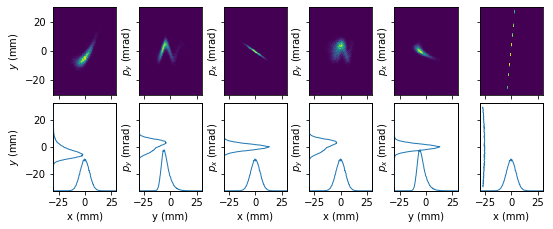

In [43]:
pairs = [["x","y"],["y","py"],["x","px"],["x","py"],["y","px"],["x","pz"]]

fig,ax = plt.subplots(2,len(pairs), sharex="col",sharey="row")
fig.subplots_adjust(wspace=0.35, right=0.975, top=0.975, hspace=0.1)
fig.set_size_inches(8,3)
    
print(all_images.shape)
plot_bins = bins
#plot_bins = plot_bins * 1e3

vmax = None
linewidth=1.0
for g, pair in enumerate(pairs):
    
    plot_bins = [bins]*2
    scale = 1e3
    if pair == ["x","pz"]:
        plot_bins = [bins]*2
    
    
    _, gt_image = add_image(ax[0][g], *pair, [gt_initial_beam], plot_bins,
                            scale_axis=scale,vmax=vmax)


    if pair[-1]=="y":
        for a in ax[:,g]:
            a.set_ylabel("$y$ (mm)")
    elif pair[-1]=="py":
        for a in ax[:,g]:
            a.set_ylabel("$p_y$ (mrad)")
    elif pair[-1]=="px":
        for a in ax[:,g]:
            a.set_ylabel("$p_x$ (mrad)")
            
    ax[-1][g].set_xlabel(pair[0] + " (mm)")
            
    

    # x projections
    max_dens = 250
    axa = ax[-1][g].twinx()
    add_projection(axa, pair[0], [gt_initial_beam], plot_bins[0], x_scale=scale, y_scale=1)
    axa.set_ylim(0,max_dens)
    axa.set_yticks([])
    
    # y projections
    axb = ax[-1][g].twiny()
    add_projection(axb, pair[1], [gt_initial_beam], plot_bins[1],axis="y",x_scale=scale, y_scale=1)
    axb.set_xlim(0,max_dens)
    axb.set_xticks([])
    
    for ele in [axa,axb]:
        for line in ele.get_lines():
            line.set(linewidth=linewidth)    
        ele.get_lines()[0].set(zorder=0)

